In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


# Conectar ao banco de dados SQLite
conn = sqlite3.connect(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\seguros.db')

df_dict = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\data\P18_dicionario_dados.csv', encoding='utf-8', sep=',')
df_cancel = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\data\P18_cancelamentos.csv', encoding='utf-8', sep=',')
df_contratos = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\data\P18_contratos.csv', encoding='utf-8', sep=',')
df_clientes= pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\data\P18_clientes.csv', encoding='utf-8', sep=',')
df_clientes.to_sql('clientes', conn, if_exists='replace', index=False)
df_contratos.to_sql('contratos', conn, if_exists='replace', index=False)
df_cancel.to_sql('cancelamentos', conn, if_exists='replace', index=False)

# Carregar as tabelas como DataFrames do pandas
df_clientes = pd.read_sql_query("SELECT * FROM clientes", conn)
df_contratos = pd.read_sql_query("SELECT * FROM contratos", conn)
df_cancel = pd.read_sql_query("SELECT * FROM cancelamentos", conn)




## 1.Perfil Demográfico do cliente

1.1 Como está divido nosso publico?



In [5]:
df_clientes['genero'].value_counts()

genero
Outro        1681
Feminino     1660
Masculino    1659
Name: count, dtype: int64

In [14]:
df_clientes['genero'].value_counts(normalize=True)*100


genero
Outro        33.62
Feminino     33.20
Masculino    33.18
Name: proportion, dtype: float64

1.2 Qual possui mais cancelamentos?

O gênero masculino possui mais cancelamentos, mas não é uma diferença significativa dos outros gêneros. Tendo em vista que estão bem divididos. 

      genero  total_cancelamentos
0  Masculino                  853
1      Outro                  841
2   Feminino                  826


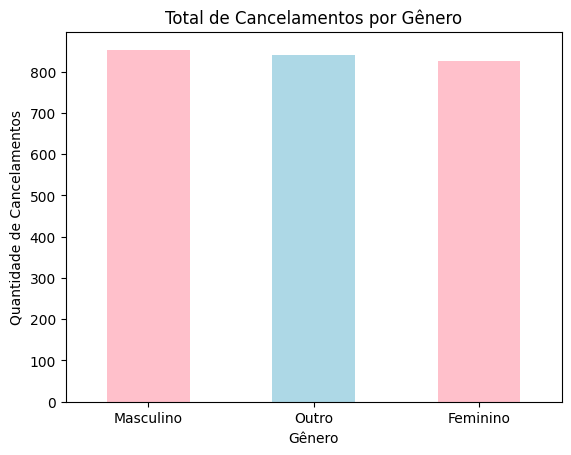

In [41]:
query = """
SELECT c.genero, COUNT(*) as total_cancelamentos
FROM cancelamentos ca
JOIN contratos co ON ca.id_contrato = co.id_contrato
JOIN clientes c ON co.id_cliente = c.id_cliente
GROUP BY c.genero
ORDER BY total_cancelamentos DESC
"""
df_cancel_por_genero = pd.read_sql_query(query, conn)
print(df_cancel_por_genero)


df_cancel_por_genero.plot(kind='bar', x='genero', y='total_cancelamentos', legend=False, color=['pink', 'lightblue'])
plt.title('Total de Cancelamentos por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Quantidade de Cancelamentos')
plt.xticks(rotation=0)
plt.show()

1.3 Como está divido as idades dos clientes?

In [42]:


query_idade = """
SELECT 
  CAST((julianday('now') - julianday(data_nascimento)) / 365.25 AS INT) AS idade, 
  COUNT(*) AS total
FROM clientes
GROUP BY idade
ORDER BY idade;
"""

df_idade_agrupada = pd.read_sql_query(query_idade, conn)
df_idade_agrupada


,idade,total
0,18,72
1,19,90
2,20,75
3,21,75
4,22,89
...,...,...
59,77,95
60,78,63
61,79,77
62,80,81


Agrupando por faixa etária

In [30]:
query_faixa = """
SELECT 
  CASE 
    WHEN idade BETWEEN 18 AND 25 THEN '18-25'
    WHEN idade BETWEEN 26 AND 35 THEN '26-35'
    WHEN idade BETWEEN 36 AND 45 THEN '36-45'
    WHEN idade BETWEEN 46 AND 60 THEN '46-60'
    ELSE '60+' 
  END AS faixa_etaria,
  COUNT(*) AS total
FROM (
  SELECT CAST((julianday('now') - julianday(data_nascimento)) / 365.25 AS INT) AS idade
  FROM clientes
)
GROUP BY faixa_etaria
ORDER BY faixa_etaria;
"""

df_faixa_etaria = pd.read_sql_query(query_faixa, conn)
print(df_faixa_etaria)


  faixa_etaria  total
0        18-25    631
1        26-35    754
2        36-45    780
3        46-60   1211
4          60+   1624


1.4 Qual faixa etária possui mais cancelamentos?

In [38]:
query_faixa_cancel = """ 
SELECT 
  CASE 
    WHEN idade BETWEEN 18 AND 25 THEN '18-25'
    WHEN idade BETWEEN 26 AND 35 THEN '26-35'
    WHEN idade BETWEEN 36 AND 45 THEN '36-45'
    WHEN idade BETWEEN 46 AND 60 THEN '46-60'
    ELSE '60+'
  END AS faixa_etaria,
  COUNT(*) AS total_cancelamentos
FROM (
  SELECT 
    cl.data_nascimento,
    CAST((julianday('now') - julianday(cl.data_nascimento)) / 365.25 AS INT) AS idade
  FROM cancelamentos ca
  JOIN contratos co ON ca.id_contrato = co.id_contrato
  JOIN clientes cl ON co.id_cliente = cl.id_cliente
)
GROUP BY faixa_etaria
ORDER BY total_cancelamentos DESC;
"""
df_faixa_cancel = pd.read_sql_query(query_faixa_cancel, conn)

df_faixa_cancel

,faixa_etaria,total_cancelamentos
0,60+,804
1,46-60,620
2,36-45,417
3,26-35,379
4,18-25,300


Qual tipo de seguro por faixa etária?

In [39]:
query_seguro_por_idade = """
SELECT 
  CASE 
    WHEN idade BETWEEN 18 AND 25 THEN '18-25'
    WHEN idade BETWEEN 26 AND 35 THEN '26-35'
    WHEN idade BETWEEN 36 AND 45 THEN '36-45'
    WHEN idade BETWEEN 46 AND 60 THEN '46-60'
    ELSE '60+'
  END AS faixa_etaria,
  co.tipo_seguro,
  COUNT(*) AS total
FROM (
  SELECT 
    cl.id_cliente,
    CAST((julianday('now') - julianday(cl.data_nascimento)) / 365.25 AS INT) AS idade
  FROM clientes cl
) AS sub
JOIN contratos co ON sub.id_cliente = co.id_cliente
GROUP BY faixa_etaria, co.tipo_seguro
ORDER BY faixa_etaria, total DESC;
"""
df_seguro_por_idade = pd.read_sql_query(query_seguro_por_idade, conn)
df_seguro_por_idade

,faixa_etaria,tipo_seguro,total
0,18-25,Empresarial,324
1,18-25,Saúde,320
2,18-25,Vida,303
3,18-25,Auto,297
4,18-25,Residencial,296
5,26-35,Empresarial,376
6,26-35,Auto,364
7,26-35,Saúde,359
8,26-35,Vida,347
9,26-35,Residencial,344


Qual tipo de seguro mais cancelado por faixa etária?

In [37]:
query_seguro_cancelado_por_idade = """
SELECT 
  CASE 
    WHEN idade BETWEEN 18 AND 25 THEN '18-25'
    WHEN idade BETWEEN 26 AND 35 THEN '26-35'
    WHEN idade BETWEEN 36 AND 45 THEN '36-45'
    WHEN idade BETWEEN 46 AND 60 THEN '46-60'
    ELSE '60+'
  END AS faixa_etaria,
  co.tipo_seguro,
  COUNT(*) AS total_cancelamentos
FROM (
  SELECT 
    cl.id_cliente,
    CAST((julianday('now') - julianday(cl.data_nascimento)) / 365.25 AS INT) AS idade
  FROM clientes cl
) AS sub
JOIN contratos co ON sub.id_cliente = co.id_cliente
Join cancelamentos ca ON co.id_contrato = ca.id_contrato
GROUP BY faixa_etaria, co.tipo_seguro
ORDER BY faixa_etaria, total_cancelamentos DESC;
"""
df_seguro_cancelado_por_idade = pd.read_sql_query(query_seguro_cancelado_por_idade, conn)
df_seguro_cancelado_por_idade

,faixa_etaria,tipo_seguro,total_cancelamentos
0,18-25,Empresarial,73
1,18-25,Saúde,68
2,18-25,Vida,60
3,18-25,Residencial,50
4,18-25,Auto,49
5,26-35,Auto,88
6,26-35,Empresarial,87
7,26-35,Saúde,77
8,26-35,Vida,68
9,26-35,Residencial,59


1.5 Como está a distribuição de clientes com dependentes?

In [46]:
query_dependentes = """
SELECT 
  CASE 
    WHEN idade BETWEEN 18 AND 25 THEN '18-25'
    WHEN idade BETWEEN 26 AND 35 THEN '26-35'
    WHEN idade BETWEEN 36 AND 45 THEN '36-45'
    WHEN idade BETWEEN 46 AND 60 THEN '46-60'
    ELSE '60+'
  END AS faixa_etaria,
  cl.qtd_dependentes,
  COUNT(*) AS total
FROM (
  SELECT 
    id_cliente,
    qtd_dependentes,
    CAST((julianday('now') - julianday(data_nascimento)) / 365.25 AS INT) AS idade
  FROM clientes
) AS cl
GROUP BY faixa_etaria, cl.qtd_dependentes
ORDER BY faixa_etaria, cl.qtd_dependentes;
"""
df_dependentes_por_faixa_etaria = pd.read_sql_query(query_dependentes, conn)
df_dependentes_por_faixa_etaria

,faixa_etaria,qtd_dependentes,total
0,18-25,0,159
1,18-25,1,193
2,18-25,2,167
3,18-25,3,71
4,18-25,4,34
5,18-25,5,7
6,26-35,0,169
7,26-35,1,251
8,26-35,2,218
9,26-35,3,78


Sem agrupar por faixa etária

In [51]:
query_dependentes_sem_idade = """
SELECT
  cl.qtd_dependentes,
  COUNT(*) AS total
FROM clientes cl
GROUP BY cl.qtd_dependentes
ORDER BY cl.qtd_dependentes;
"""
df_dependentes_sem_idade = pd.read_sql_query(query_dependentes_sem_idade, conn)
df_dependentes_sem_idade

,qtd_dependentes,total
0,0,1131
1,1,1665
2,2,1311
3,3,595
4,4,218
5,5,59
6,6,18
7,7,2
8,8,1


1.6 Clientes com dependentes (filhos, cônjuges) cancelam mais ou menos? 

In [47]:
query_dependentes_rel_cancel = """
SELECT 
  cl.qtd_dependentes,
  COUNT(*) AS total_cancelamentos
FROM cancelamentos ca
JOIN contratos co ON ca.id_contrato = co.id_contrato
JOIN clientes cl ON co.id_cliente = cl.id_cliente
GROUP BY cl.qtd_dependentes
ORDER BY cl.qtd_dependentes;
"""

df_dependentes_rel_cancel = pd.read_sql_query(query_dependentes_rel_cancel, conn)
df_dependentes_rel_cancel

,qtd_dependentes,total_cancelamentos
0,0,576
1,1,831
2,2,661
3,3,300
4,4,109
5,5,30
6,6,11
7,7,1
8,8,1


1.7 Quantos tipos de profissões temos?

In [67]:
query_profissoes_tipos = """ 
SELECT cl.profissao, 
    count(*) AS total
FROM clientes cl 
GROUP BY cl.profissao
ORDER BY total;
"""

df_profissoes_agroup = pd.read_sql_query(query_profissoes_tipos, conn)
df_profissoes_agroup

,profissao,total
0,Despachante,1
1,Engenheiro têxtil,1
2,Estivador,1
3,Estoquista,1
4,Tecnólogo em automação industrial,1
...,...,...
743,Tecnólogo em produção de bebidas,14
744,Tintureiro,14
745,Recreador,15
746,Sociólogo,15


1.8 Existe alguma profissão mais comum?

In [76]:

df_profissoes_agroup.loc[df_profissoes_agroup['total'].idxmax()]


profissao    Ginecologista
total                   16
Name: 747, dtype: object

1.9 Clientes com profissões específicas tendem a cancelar mais?

In [57]:
query_profissoes_cancel = """
SELECT 
  cl.profissao,
  COUNT(DISTINCT cl.id_cliente) AS total_profissoes,
  COUNT(ca.id_contrato) AS total_cancelamentos
FROM clientes cl
LEFT JOIN contratos co ON cl.id_cliente = co.id_cliente
LEFT JOIN cancelamentos ca ON co.id_contrato = ca.id_contrato
GROUP BY cl.profissao
ORDER BY total_cancelamentos DESC;
"""
df_profissoes_agroup_cancel = pd.read_sql_query(query_profissoes_cancel, conn)
df_profissoes_agroup_cancel

,profissao,total_profissoes,total_cancelamentos
0,Patinador,14,14
1,Mãe social,13,13
2,Esgrimista,14,12
3,Teólogo,13,11
4,Tecnólogo em produção de bebidas,14,11
...,...,...,...
743,Apresentador,5,0
744,Analista de sistemas,3,0
745,Ambulante,6,0
746,Aeronauta,5,0


1.10 Qual é o nível educacional dos nossos clientes?

In [66]:
query_nivel_educacional_agroup = """ 
SELECT cl.nivel_educacional, 
    count(*) AS total
FROM clientes cl 
GROUP BY cl.nivel_educacional
ORDER BY total
"""

df_nivel_educacional_agroup = pd.read_sql_query(query_nivel_educacional_agroup, conn)
df_nivel_educacional_agroup


,nivel_educacional,total
0,Pós,979
1,Superior,986
2,Técnico,994
3,Fundamental,1007
4,Médio,1034


1.11 Qual a relação entre cancelamento e nível educacional?

In [ ]:
query_nivel_educacional_agroup_cancel = """
SELECT 
  cl.nivel_educacional,
  COUNT(DISTINCT cl.id_cliente) AS total_clientes,
  COUNT(ca.id_contrato) AS total_cancelamentos
FROM clientes cl
LEFT JOIN contratos co ON cl.id_cliente = co.id_cliente
LEFT JOIN cancelamentos ca ON co.id_contrato = ca.id_contrato
GROUP BY cl.nivel_educacional
ORDER BY total_cancelamentos DESC;
"""
df_nivel_educacional_agroup_cancel = pd.read_sql_query(query_nivel_educacional_agroup_cancel, conn)
df_nivel_educacional_agroup_cancel

,nivel_educacional,total_clientes,total_cancelamentos
0,Fundamental,1007,531
1,Superior,986,510
2,Médio,1034,510
3,Pós,979,487
4,Técnico,994,482


## 2.Perfil Financeiro e Pagamento

2.1 Média de valor do seguro pago por idade.

In [ ]:
query_media_seguro_por_idade = """ 
SELECT 
  CASE 
    WHEN idade BETWEEN 18 AND 25 THEN '18-25'
    WHEN idade BETWEEN 26 AND 35 THEN '26-35'
    WHEN idade BETWEEN 36 AND 45 THEN '36-45'
    WHEN idade BETWEEN 46 AND 60 THEN '46-60'
    ELSE '60+'
  END AS faixa_etaria,
  AVG(co.valor_premio_mensal) AS media_valor_mensal
FROM (
  SELECT 
    cl.id_cliente,
    CAST((julianday('now') - julianday(cl.data_nascimento)) / 365.25 AS INT) AS idade
  FROM clientes cl
) AS sub
JOIN contratos co ON sub.id_cliente = co.id_cliente
GROUP BY faixa_etaria
ORDER BY faixa_etaria;

"""

df_media_seguro_por_idade = pd.read_sql_query(query_media_seguro_por_idade, conn)
df_media_seguro_por_idade.round(2)

,faixa_etaria,media_valor_mensal
0,18-25,783.97
1,26-35,792.79
2,36-45,775.17
3,46-60,783.58
4,60+,777.80


2.2 Valor médio paga impacta no cancelamento?

In [82]:
query_valor_cancel_faixa = """
SELECT 
  CASE 
    WHEN idade BETWEEN 18 AND 25 THEN '18-25'
    WHEN idade BETWEEN 26 AND 35 THEN '26-35'
    WHEN idade BETWEEN 36 AND 45 THEN '36-45'
    WHEN idade BETWEEN 46 AND 60 THEN '46-60'
    ELSE '60+'
  END AS faixa_etaria,
  AVG(co.valor_premio_mensal) AS media_valor_mensal,
  COUNT(ca.id_contrato) AS total_cancelamentos
FROM (
  SELECT 
    cl.id_cliente,
    CAST((julianday('now') - julianday(cl.data_nascimento)) / 365.25 AS INT) AS idade
  FROM clientes cl
) AS sub
JOIN contratos co ON sub.id_cliente = co.id_cliente
LEFT JOIN cancelamentos ca ON co.id_contrato = ca.id_contrato
GROUP BY faixa_etaria
ORDER BY faixa_etaria;
"""

df_valor_cancel_faixa = pd.read_sql_query(query_valor_cancel_faixa, conn)
print(df_valor_cancel_faixa)

  faixa_etaria  media_valor_mensal  total_cancelamentos
0        18-25          783.971175                  300
1        26-35          792.792453                  379
2        36-45          775.165637                  417
3        46-60          783.584383                  620
4          60+          777.804893                  804


2.3 Qual a média de valor do plano por cliente?

  faixa_etaria  media_valor_mensal  total_cancelamentos
0        18-25          783.971175                  300
1        26-35          792.792453                  379
2        36-45          775.165637                  417
3        46-60          783.584383                  620
4          60+          777.804893                  804


Valor médio por tipo de plano

In [83]:
query_valor_por_tipo = """
SELECT 
  tipo_seguro,
  AVG(valor_premio_mensal) AS media_valor_mensal
FROM contratos
GROUP BY tipo_seguro
ORDER BY media_valor_mensal DESC;
"""

df_valor_por_tipo = pd.read_sql_query(query_valor_por_tipo, conn)
print(df_valor_por_tipo)

   tipo_seguro  media_valor_mensal
0  Residencial          791.598784
1  Empresarial          784.393966
2        Saúde          781.450582
3         Vida          778.476463
4         Auto          773.443067


2.4 Há histórico de pagamentos por cliente?

In [85]:
query_contratos_por_cliente = """
SELECT 
  cl.id_cliente,
  cl.nome,
  COUNT(co.id_contrato) AS total_contratos
FROM clientes cl
JOIN contratos co ON cl.id_cliente = co.id_cliente
GROUP BY cl.id_cliente, cl.nome
ORDER BY total_contratos DESC;
"""

df_contratos_por_cliente = pd.read_sql_query(query_contratos_por_cliente, conn)
print(df_contratos_por_cliente)

df_mais_de_um = df_contratos_por_cliente[df_contratos_por_cliente['total_contratos'] > 1]
print(f"{len(df_mais_de_um)} clientes possuem mais de 1 contrato.")

     id_cliente                   nome  total_contratos
0        C02589     Alice da Conceição               11
1        C00212           Thomas Pires                9
2        C00922        Bárbara Moreira                9
3        C03146  Luiz Fernando Barbosa                9
4        C03860      Mariane Fernandes                9
...         ...                    ...              ...
4544     C04965         Julia Monteiro                1
4545     C04968           Alícia Ramos                1
4546     C04978        Sr. Caio Araújo                1
4547     C04983     Sra. Maria Rezende                1
4548     C04994    Sr. Davi Cavalcanti                1

[4549 rows x 3 columns]
3464 clientes possuem mais de 1 contrato.


Quantas pessoas (clientes) têm mais de um contrato e pelo menos um foi cancelado?

In [86]:
query_clientes_multiplos_cancelados = """
SELECT 
  cl.id_cliente,
  cl.nome,
  COUNT(DISTINCT co.id_contrato) AS total_contratos,
  COUNT(DISTINCT ca.id_contrato) AS total_cancelados
FROM clientes cl
JOIN contratos co ON cl.id_cliente = co.id_cliente
LEFT JOIN cancelamentos ca ON co.id_contrato = ca.id_contrato
GROUP BY cl.id_cliente, cl.nome
HAVING total_contratos > 1 AND total_cancelados > 0
ORDER BY total_cancelados DESC;
"""

df_clientes_multiplos_cancelados = pd.read_sql_query(query_clientes_multiplos_cancelados, conn)
print(df_clientes_multiplos_cancelados)
print(f"\nTotal de clientes com >1 contrato e pelo menos 1 cancelado: {len(df_clientes_multiplos_cancelados)}")

     id_cliente                    nome  total_contratos  total_cancelados
0        C00022    Luiz Gustavo Rezende                7                 4
1        C00994    João Guilherme Costa                6                 4
2        C01277        Davi Lucas Lopes                6                 4
3        C01304          Vitor Nogueira                5                 4
4        C02115  Dr. Vitor Hugo Cardoso                7                 4
...         ...                     ...              ...               ...
1749     C04989           Raul Ferreira                4                 1
1750     C04995             Lívia Moura                2                 1
1751     C04996        Ana Júlia Farias                4                 1
1752     C04998      Luiz Otávio Mendes                2                 1
1753     C04999            Agatha Alves                4                 1

[1754 rows x 4 columns]

Total de clientes com >1 contrato e pelo menos 1 cancelado: 1754


Quantos clientes com apenas um contrato que cancelaram?


In [87]:
query_um_contrato_cancelado = """
SELECT 
  cl.id_cliente,
  cl.nome,
  COUNT(DISTINCT co.id_contrato) AS total_contratos,
  COUNT(DISTINCT ca.id_contrato) AS total_cancelados
FROM clientes cl
JOIN contratos co ON cl.id_cliente = co.id_cliente
LEFT JOIN cancelamentos ca ON co.id_contrato = ca.id_contrato
GROUP BY cl.id_cliente, cl.nome
HAVING total_contratos = 1 AND total_cancelados = 1
ORDER BY cl.nome;
"""

df_um_contrato_cancelado = pd.read_sql_query(query_um_contrato_cancelado, conn)
print(df_um_contrato_cancelado)
print(f"\nTotal de clientes com 1 contrato cancelado: {len(df_um_contrato_cancelado)}")

    id_cliente                 nome  total_contratos  total_cancelados
0       C03082        Agatha Mendes                1                 1
1       C00771       Alana Caldeira                1                 1
2       C02530      Alexandre Alves                1                 1
3       C02598  Alexandre Rodrigues                1                 1
4       C00924       Alice Ferreira                1                 1
..         ...                  ...              ...               ...
214     C01013    Vitor Hugo Moraes                1                 1
215     C02926   Vitor Hugo da Rosa                1                 1
216     C01331      Vitória Cardoso                1                 1
217     C01253         Yago Pereira                1                 1
218     C01583        Yasmin Moraes                1                 1

[219 rows x 4 columns]

Total de clientes com 1 contrato cancelado: 219


Clientes que possuem apenas um contrato, como é a modalidade de tempo de contrato deles?

In [88]:
query_duracao_um_contrato = """
SELECT 
  cl.id_cliente,
  cl.nome,
  co.data_inicio,
  co.data_fim,
  julianday(co.data_fim) - julianday(co.data_inicio) AS duracao_dias
FROM clientes cl
JOIN contratos co ON cl.id_cliente = co.id_cliente
LEFT JOIN (
    SELECT id_cliente
    FROM contratos
    GROUP BY id_cliente
    HAVING COUNT(*) > 1
) multi_contratos ON cl.id_cliente = multi_contratos.id_cliente
WHERE multi_contratos.id_cliente IS NULL
"""

df_duracao_um_contrato = pd.read_sql_query(query_duracao_um_contrato, conn)
print(df_duracao_um_contrato.head())

# Estatísticas básicas
print(df_duracao_um_contrato['duracao_dias'].describe())


  id_cliente                nome data_inicio    data_fim  duracao_dias
0     C00002  Matheus Nascimento  2024-09-14  2025-03-13         180.0
1     C00003  Sra. Pietra Farias  2023-10-29  2025-10-28         730.0
2     C00004    Vicente Ferreira  2024-03-05  2025-03-05         365.0
3     C00006       Murilo Moraes  2023-07-23  2025-07-22         730.0
4     C00011       Stella Aragão  2024-05-31  2024-11-27         180.0
count    1085.000000
mean      419.824885
std       227.282431
min       180.000000
25%       180.000000
50%       365.000000
75%       730.000000
max       730.000000
Name: duracao_dias, dtype: float64


2.5 Clientes que pagam anualmente tem menor taxa de cancelamento?

In [96]:
query_taxa_cancel_anual = """
WITH contratos_duracao AS (
  SELECT 
    co.*,
    julianday(co.data_fim) - julianday(co.data_inicio) AS duracao_dias,
    CASE 
      WHEN julianday(co.data_fim) - julianday(co.data_inicio) >= 330 THEN 'Anual'
      ELSE 'Outros'
    END AS tipo_contrato
  FROM contratos co
)

SELECT 
  tipo_contrato,
  co.tipo_seguro,
  COUNT(co.id_contrato) AS total_contratos,
  COUNT(ca.id_contrato) AS total_cancelamentos,
  ROUND( (CAST(COUNT(ca.id_contrato) AS FLOAT) / COUNT(co.id_contrato)) * 100, 2) AS taxa_cancelamento_percentual
FROM contratos_duracao co
LEFT JOIN cancelamentos ca ON co.id_contrato = ca.id_contrato
GROUP BY tipo_contrato, co.tipo_seguro
ORDER BY tipo_contrato, taxa_cancelamento_percentual ASC;
"""

df_taxa_cancel_anual = pd.read_sql_query(query_taxa_cancel_anual, conn)
print(df_taxa_cancel_anual)


  tipo_contrato  tipo_seguro  total_contratos  total_cancelamentos  \
0         Anual         Auto             1655                  296   
1         Anual         Vida             1578                  315   
2         Anual  Residencial             1544                  317   
3         Anual  Empresarial             1608                  346   
4         Anual        Saúde             1609                  354   
5        Outros         Vida              828                  174   
6        Outros  Empresarial              815                  176   
7        Outros        Saúde              781                  174   
8        Outros         Auto              774                  173   
9        Outros  Residencial              808                  195   

   taxa_cancelamento_percentual  
0                         17.89  
1                         19.96  
2                         20.53  
3                         21.52  
4                         22.00  
5                        

2.6 Clientes que renovam automaticamente são mais fieis ou tendem a cancelar?

In [97]:
query_renovacao_cancelamento = """
SELECT 
  co.renovado_automaticamente,
  COUNT(co.id_contrato) AS total_contratos,
  COUNT(ca.id_contrato) AS total_cancelamentos,
  ROUND( (CAST(COUNT(ca.id_contrato) AS FLOAT) / COUNT(co.id_contrato)) * 100, 2) AS taxa_cancelamento_percentual
FROM contratos co
LEFT JOIN cancelamentos ca ON co.id_contrato = ca.id_contrato
GROUP BY co.renovado_automaticamente;
"""

df_renovacao_cancelamento = pd.read_sql_query(query_renovacao_cancelamento, conn)
print(df_renovacao_cancelamento)

   renovado_automaticamente  total_contratos  total_cancelamentos  \
0                         0             5954                 1254   
1                         1             6046                 1266   

   taxa_cancelamento_percentual  
0                         21.06  
1                         20.94  


2.7 Verificando quantos contratos expirados temos

In [3]:
query_contratos_expirados = """
SELECT *
FROM contratos
WHERE DATE(data_fim) < DATE('now');
"""
df_contratos_expirados = pd.read_sql_query(query_contratos_expirados, conn)
df_contratos_expirados

,id_contrato,id_cliente,tipo_seguro,data_inicio,data_fim,valor_premio_mensal,satisfacao_ultima_avaliacao,canal_venda,renovado_automaticamente
0,63d107e8-f5ee-4df0-807a-4f27b0906442,C04508,Empresarial,2023-02-18,2023-08-17,892.30,Média,Site,0
1,036e784d-6795-473f-8097-962d41257043,C00331,Vida,2024-12-12,2025-06-10,511.69,Baixa,App,0
2,2300ac83-89de-49dc-bead-52c95f761041,C01590,Residencial,2023-09-16,2024-09-15,417.14,Baixa,Corretor,0
3,318fc49f-635d-406d-8e6f-4438ad560b1b,C00378,Vida,2024-09-27,2025-03-26,996.09,Baixa,App,1
4,2d4f5f9d-4ec8-4b95-a979-4435c45d3019,C00840,Residencial,2022-11-11,2024-11-10,721.18,Baixa,App,1
...,...,...,...,...,...,...,...,...,...
7426,aa4e1fd7-2715-473e-9749-535bb6473a49,C00231,Saúde,2023-12-07,2024-06-04,1390.41,Média,Agência Física,0
7427,ec2044b0-35be-4cc1-8318-81c0c4243e44,C00016,Vida,2022-10-23,2024-10-22,599.48,Alta,Agência Física,1
7428,b7617e1b-f563-457d-951a-d8d2ef4a4e90,C00922,Saúde,2023-10-26,2024-04-23,607.17,Alta,App,1
7429,05bb6166-72cc-46cc-9fc4-9082fef6b857,C00312,Residencial,2023-05-31,2023-11-27,334.17,Baixa,Agência Física,0
